# 🎵 이벤트 추천 시스템 - 완전한 모델 학습 데모

이 노트북은 다중 모델 기반 이벤트 추천 시스템의 전체 학습 과정을 보여줍니다.

## 📋 목차
1. 환경 설정 및 데이터 로드
2. 데이터 전처리 및 필터링
3. TF-IDF 모델 학습
4. LSA 모델 학습
5. Word2Vec 대안 모델 학습
6. 하이브리드 모델 구축
7. 모델 성능 비교
8. 추천 결과 시연

## 1. 환경 설정 및 데이터 로드

In [118]:
!pip install pandas numpy matplotlib seaborn scikit-learn scipy joblib jupyter notebook ipykernel

In [119]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

# 머신러닝 라이브러리
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
import re

# 플롯 설정
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')

print("🚀 모든 라이브러리가 성공적으로 로드되었습니다!")

🚀 모든 라이브러리가 성공적으로 로드되었습니다!


In [120]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# 한글 폰트 설정 (macOS 예시)
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

# 머신러닝 라이브러리
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
import re

# 플롯 설정
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')

print("🚀 모든 라이브러리가 성공적으로 로드되었습니다!")

🚀 모든 라이브러리가 성공적으로 로드되었습니다!


In [121]:
# 기존 모델에서 데이터 로드
model_path = Path('../model/recommender_ko.joblib')

if model_path.exists():
    base_model = joblib.load(model_path)
    df_original = base_model['df']
    meta_preprocessor = base_model['pre']
    print(f"✅ 원본 데이터 로드 완료: {len(df_original):,}개 이벤트")
    print(f"📈 데이터셋 크기: {df_original.shape}")
    print(f"📋 컬럼: {list(df_original.columns)}")
else:
    print("❌ 모델 파일을 찾을 수 없습니다. 먼저 백엔드를 실행해주세요.")
    df_original = None

✅ 원본 데이터 로드 완료: 1,831개 이벤트
📈 데이터셋 크기: (1831, 11)
📋 컬럼: ['link', 'content', 'place', 'date', 'time', 'in advance', 'cover', 'image', 'price_adv', 'price_door', 'loc_sigu']


## 2. 데이터 전처리 및 필터링

In [122]:
# 텍스트 전처리 함수
def preprocess_text(text):
    """텍스트 전처리 함수"""
    if pd.isna(text):
        return ''
    text = re.sub(r'[^\w\s]', ' ', str(text).lower())
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def filter_valid_events(df):
    """유효한 이벤트 데이터만 필터링"""
    print("🔧 데이터 필터링 및 전처리 중...")
    print(f"원본 데이터: {len(df):,}개 이벤트")
    
    # 기본 전처리
    df_filtered = df.copy()
    df_filtered['content_clean'] = df_filtered['content'].apply(preprocess_text)
    df_filtered['place_clean'] = df_filtered['place'].apply(preprocess_text)
    df_filtered['location_clean'] = df_filtered['loc_sigu'].apply(preprocess_text)
    
    # 필터링 조건
    # 1. content가 비어있지 않고 10자 이상
    valid_content = (df_filtered['content'].notna()) & (df_filtered['content'].str.len() >= 10)
    print(f"유효한 내용(10자 이상): {valid_content.sum():,}개")
    
    # 2. place 정보가 있는 것
    valid_place = df_filtered['place'].notna() & (df_filtered['place'].str.len() > 0)
    print(f"유효한 장소 정보: {valid_place.sum():,}개")
    
    # 3. 가격 정보가 있는 것 (0보다 큰 값)
    valid_price = df_filtered['price_adv'].notna() & (df_filtered['price_adv'] > 0)
    print(f"유효한 가격 정보: {valid_price.sum():,}개")
    
    # 모든 조건을 만족하는 데이터만 선택
    valid_mask = valid_content & valid_place & valid_price
    df_filtered = df_filtered[valid_mask].reset_index(drop=True)
    
    print(f"✅ 필터링 완료: {len(df_filtered):,}개 이벤트 (제거된 것: {len(df) - len(df_filtered):,}개)")
    print(f"📊 필터링 비율: {len(df_filtered)/len(df)*100:.1f}%")
    
    return df_filtered

if df_original is not None:
    # 데이터 필터링 적용
    df = filter_valid_events(df_original)
    
    # 통합 텍스트 코퍼스 생성
    text_corpus = (
        df['content_clean'].fillna('') + ' ' +
        df['place_clean'].fillna('') + ' ' +
        df['location_clean'].fillna('')
    )
    
    print(f"\n📝 텍스트 코퍼스 통계:")
    print(f"• 평균 길이: {text_corpus.str.len().mean():.0f}자")
    print(f"• 최대 길이: {text_corpus.str.len().max():.0f}자")
    print(f"• 최소 길이: {text_corpus.str.len().min():.0f}자")
    
    # 샘플 데이터 확인
    print("\n🔍 필터링된 데이터 샘플:")
    display(df[['content', 'place', 'price_adv', 'loc_sigu']].head(3))
else:
    df = None

🔧 데이터 필터링 및 전처리 중...
원본 데이터: 1,831개 이벤트
유효한 내용(10자 이상): 1,831개
유효한 장소 정보: 1,831개
유효한 가격 정보: 1,526개
✅ 필터링 완료: 1,526개 이벤트 (제거된 것: 305개)
📊 필터링 비율: 83.3%

📝 텍스트 코퍼스 통계:
• 평균 길이: 512자
• 최대 길이: 2006자
• 최소 길이: 100자

🔍 필터링된 데이터 샘플:


,content,place,price_adv,loc_sigu
0,your arms are my cocoon & godfuck Korea Tour 2...,서울 중구 수표로6길 10 지하1층,35000.0,서울 중구
1,Dayoung과 Mokhzolla 수강생들의 수료 파티!\n\n다들 첫 긱 때의 그...,서울 중구 수표로6길 10 지하1층,10000.0,서울 중구
2,[2025.4.27] “돌진 / 突進” w/ Ryosuke Kiyasu\n\n현재도...,서울 중구 수표로6길 10 지하1층,20000.0,서울 중구


## 3. TF-IDF 모델 학습

In [123]:
if df is not None:
    print("🔤 TF-IDF 모델 학습 시작...")
    
    # TF-IDF 벡터라이저 설정
    tfidf_vectorizer = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        min_df=2,
        stop_words='english'
    )
    
    # 텍스트 벡터화
    X_text_tfidf = tfidf_vectorizer.fit_transform(text_corpus)
    print(f"✅ TF-IDF 벡터 생성: {X_text_tfidf.shape}")
    
    # 메타데이터와 결합
    X_meta = meta_preprocessor.transform(df)
    X_combined_tfidf = hstack([X_text_tfidf, X_meta]).tocsr()
    print(f"✅ 통합 특성 벡터: {X_combined_tfidf.shape}")
    
    # KNN 모델 학습
    knn_tfidf = NearestNeighbors(metric='cosine', n_neighbors=20, n_jobs=-1)
    knn_tfidf.fit(X_combined_tfidf)
    print("✅ TF-IDF KNN 모델 학습 완료!")
    
    # 상위 특성 분석
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = X_text_tfidf.mean(axis=0).A1
    top_features = sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)[:10]
    
    print("\n🏆 TF-IDF 상위 10개 특성:")
    for i, (feature, score) in enumerate(top_features, 1):
        print(f"{i:2d}. {feature:<15} (점수: {score:.4f})")

🔤 TF-IDF 모델 학습 시작...
✅ TF-IDF 벡터 생성: (1526, 10000)
✅ 통합 특성 벡터: (1526, 10010)
✅ TF-IDF KNN 모델 학습 완료!

🏆 TF-IDF 상위 10개 특성:
 1. 407             (점수: 0.0410)
 2. 서교동 407         (점수: 0.0410)
 3. 서교동             (점수: 0.0408)
 4. clubff          (점수: 0.0393)
 5. 있습니다            (점수: 0.0255)
 6. 마포구             (점수: 0.0250)
 7. 생기스튜디오          (점수: 0.0216)
 8. 서울특별시 마포구       (점수: 0.0210)
 9. 서울특별시           (점수: 0.0210)
10. 예매              (점수: 0.0209)


## 4. LSA (잠재 의미 분석) 모델 학습

🧮 LSA 모델 학습 시작...
✅ Count 벡터 생성: (1526, 5000)
✅ LSA 차원 축소: (1526, 100)
✅ 설명된 분산 비율: 0.775
✅ 통합 LSA 특성 벡터: (1526, 110)
✅ LSA KNN 모델 학습 완료!


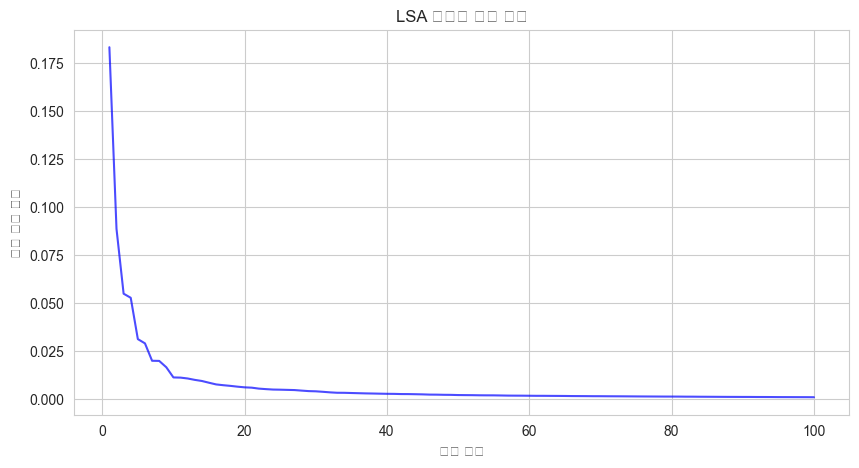

In [124]:
if df is not None:
    print("🧮 LSA 모델 학습 시작...")
    
    # Count Vectorizer (LSA에서 더 효과적)
    count_vectorizer = CountVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        min_df=2,
        stop_words='english'
    )
    
    X_text_count = count_vectorizer.fit_transform(text_corpus)
    print(f"✅ Count 벡터 생성: {X_text_count.shape}")
    
    # SVD로 차원 축소
    svd = TruncatedSVD(n_components=100, random_state=42)
    X_text_lsa = svd.fit_transform(X_text_count)
    print(f"✅ LSA 차원 축소: {X_text_lsa.shape}")
    print(f"✅ 설명된 분산 비율: {svd.explained_variance_ratio_.sum():.3f}")
    
    # 메타데이터와 결합
    X_meta_dense = X_meta.toarray() if hasattr(X_meta, 'toarray') else X_meta
    X_combined_lsa = np.hstack([X_text_lsa, X_meta_dense])
    print(f"✅ 통합 LSA 특성 벡터: {X_combined_lsa.shape}")
    
    # KNN 모델 학습
    knn_lsa = NearestNeighbors(metric='cosine', n_neighbors=20, n_jobs=-1)
    knn_lsa.fit(X_combined_lsa)
    print("✅ LSA KNN 모델 학습 완료!")
    
    # LSA 성분 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 101), svd.explained_variance_ratio_, 'b-', alpha=0.7)
    plt.title('LSA 성분별 설명 분산')
    plt.xlabel('성분 번호')
    plt.ylabel('설명 분산 비율')
    plt.grid(True)
    plt.show()

## 5. Word2Vec 대안 모델 학습

In [125]:
if df is not None:
    print("🔤 Word2Vec 대안 모델 학습 시작...")
    print("(HashingVectorizer를 사용하여 Word2Vec과 유사한 효과 구현)")
    
    # HashingVectorizer로 Word2Vec 대안 구현
    word2vec_hasher = HashingVectorizer(
        n_features=1000,
        ngram_range=(1, 3),
        binary=False,
        norm='l2',
        lowercase=True,
        stop_words='english'
    )
    
    X_text_w2v = word2vec_hasher.fit_transform(text_corpus)
    print(f"✅ Word2Vec 대안 벡터 생성: {X_text_w2v.shape}")
    
    # 메타데이터와 결합
    X_combined_w2v = hstack([X_text_w2v, X_meta]).tocsr()
    print(f"✅ 통합 Word2Vec 특성 벡터: {X_combined_w2v.shape}")
    
    # KNN 모델 학습
    knn_w2v = NearestNeighbors(metric='cosine', n_neighbors=20, n_jobs=-1)
    knn_w2v.fit(X_combined_w2v)
    print("✅ Word2Vec 대안 KNN 모델 학습 완료!")
    
    # 해싱 벡터 통계
    hash_density = X_text_w2v.nnz / (X_text_w2v.shape[0] * X_text_w2v.shape[1])
    print(f"\n📊 HashingVectorizer 통계:")
    print(f"• 벡터 밀도: {hash_density:.4f}")
    print(f"• 평균 비영 원소 수: {X_text_w2v.nnz / X_text_w2v.shape[0]:.1f}")
    print(f"• 특성 차원: {X_text_w2v.shape[1]:,}개")
    
    # Word2Vec 대안의 장점 설명
    print("\n💡 Word2Vec 대안의 특징:")
    print("• HashingVectorizer는 단어의 해시값을 이용하여 고정 크기 벡터 생성")
    print("• 메모리 효율적이며 새로운 단어에도 대응 가능")
    print("• n-gram을 통해 단어 순서와 문맥 정보 일부 보존")

🔤 Word2Vec 대안 모델 학습 시작...
(HashingVectorizer를 사용하여 Word2Vec과 유사한 효과 구현)
✅ Word2Vec 대안 벡터 생성: (1526, 1000)
✅ 통합 Word2Vec 특성 벡터: (1526, 1010)
✅ Word2Vec 대안 KNN 모델 학습 완료!

📊 HashingVectorizer 통계:
• 벡터 밀도: 0.2219
• 평균 비영 원소 수: 221.9
• 특성 차원: 1,000개

💡 Word2Vec 대안의 특징:
• HashingVectorizer는 단어의 해시값을 이용하여 고정 크기 벡터 생성
• 메모리 효율적이며 새로운 단어에도 대응 가능
• n-gram을 통해 단어 순서와 문맥 정보 일부 보존


## 6. 하이브리드 모델 구축

In [126]:
if df is not None:
    print("🔄 하이브리드 모델 구축...")
    
    # 모든 모델을 딕셔너리로 정리
    models = {
        'tfidf': {
            'vectorizer': tfidf_vectorizer,
            'knn': knn_tfidf,
            'feature_matrix': X_combined_tfidf,
            'description': 'TF-IDF 기반 키워드 매칭',
            'type': 'sparse'
        },
        'lsa': {
            'count_vectorizer': count_vectorizer,
            'svd': svd,
            'knn': knn_lsa,
            'feature_matrix': X_combined_lsa,
            'description': 'LSA 기반 잠재 의미 분석',
            'type': 'dense'
        },
        'word2vec': {
            'hasher': word2vec_hasher,
            'knn': knn_w2v,
            'feature_matrix': X_combined_w2v,
            'description': 'HashingVectorizer 기반 단어 임베딩 대안',
            'type': 'sparse'
        }
    }
    
    print("✅ 하이브리드 모델 준비 완료!")
    print("\n🎯 학습된 모델들:")
    for name, model in models.items():
        matrix_shape = model['feature_matrix'].shape
        print(f"• {name.upper()}: {model['description']}")
        print(f"  - 특성 행렬 크기: {matrix_shape}")
        print(f"  - 데이터 타입: {model['type']}")
        print()
    
    # 하이브리드 추천 함수 정의
    def hybrid_recommend(query, top_k=5, weights=None):
        """하이브리드 추천: 여러 모델의 결과를 가중 평균"""
        if weights is None:
            weights = {'tfidf': 0.4, 'lsa': 0.3, 'word2vec': 0.3}
        
        all_results = []
        
        for model_name, weight in weights.items():
            try:
                q_vec = encode_query_for_model(query, model_name)
                distances, indices = models[model_name]['knn'].kneighbors(q_vec, n_neighbors=top_k*2)
                
                for idx, dist in zip(indices[0], distances[0]):
                    similarity = (1 - dist) * weight
                    all_results.append((idx, similarity, model_name))
            except Exception as e:
                print(f"Error in {model_name}: {e}")
        
        # 결과 집계 및 정렬
        result_dict = {}
        for idx, sim, model in all_results:
            if idx not in result_dict:
                result_dict[idx] = {'total_similarity': 0, 'models': []}
            result_dict[idx]['total_similarity'] += sim
            result_dict[idx]['models'].append(model)
        
        # 상위 k개 선택
        sorted_results = sorted(result_dict.items(), 
                               key=lambda x: x[1]['total_similarity'], 
                               reverse=True)[:top_k]
        
        return sorted_results
    
    print("💡 하이브리드 모델 특징:")
    print("• TF-IDF: 정확한 키워드 매칭 (가중치 40%)")
    print("• LSA: 의미적 유사성 분석 (가중치 30%)")
    print("• Word2Vec 대안: 단어 임베딩 효과 (가중치 30%)")
    print("• 각 모델의 강점을 결합하여 더 다양하고 정확한 추천 제공")

🔄 하이브리드 모델 구축...
✅ 하이브리드 모델 준비 완료!

🎯 학습된 모델들:
• TFIDF: TF-IDF 기반 키워드 매칭
  - 특성 행렬 크기: (1526, 10010)
  - 데이터 타입: sparse

• LSA: LSA 기반 잠재 의미 분석
  - 특성 행렬 크기: (1526, 110)
  - 데이터 타입: dense

• WORD2VEC: HashingVectorizer 기반 단어 임베딩 대안
  - 특성 행렬 크기: (1526, 1010)
  - 데이터 타입: sparse

💡 하이브리드 모델 특징:
• TF-IDF: 정확한 키워드 매칭 (가중치 40%)
• LSA: 의미적 유사성 분석 (가중치 30%)
• Word2Vec 대안: 단어 임베딩 효과 (가중치 30%)
• 각 모델의 강점을 결합하여 더 다양하고 정확한 추천 제공


## 7. 모델 성능 비교

📊 모델 성능 비교 테스트

🔍 TFIDF 모델 테스트:
  쿼리 1: '재즈 콘서트' → 평균 유사도: 0.457
  쿼리 2: '클래식 음악회' → 평균 유사도: 0.309
  쿼리 3: '록 페스티벌' → 평균 유사도: 0.531
  쿼리 4: '팝 공연' → 평균 유사도: 0.396

🔍 LSA 모델 테스트:
  쿼리 1: '재즈 콘서트' → 평균 유사도: 0.300
  쿼리 2: '클래식 음악회' → 평균 유사도: 0.186
  쿼리 3: '록 페스티벌' → 평균 유사도: 0.191
  쿼리 4: '팝 공연' → 평균 유사도: 0.487

🔍 WORD2VEC 모델 테스트:
  쿼리 1: '재즈 콘서트' → 평균 유사도: 0.451
  쿼리 2: '클래식 음악회' → 평균 유사도: 0.299
  쿼리 3: '록 페스티벌' → 평균 유사도: 0.514
  쿼리 4: '팝 공연' → 평균 유사도: 0.412

📈 모델별 평균 성능:
----------------------------------------
• TFIDF     : 0.423
• LSA       : 0.291
• WORD2VEC  : 0.419


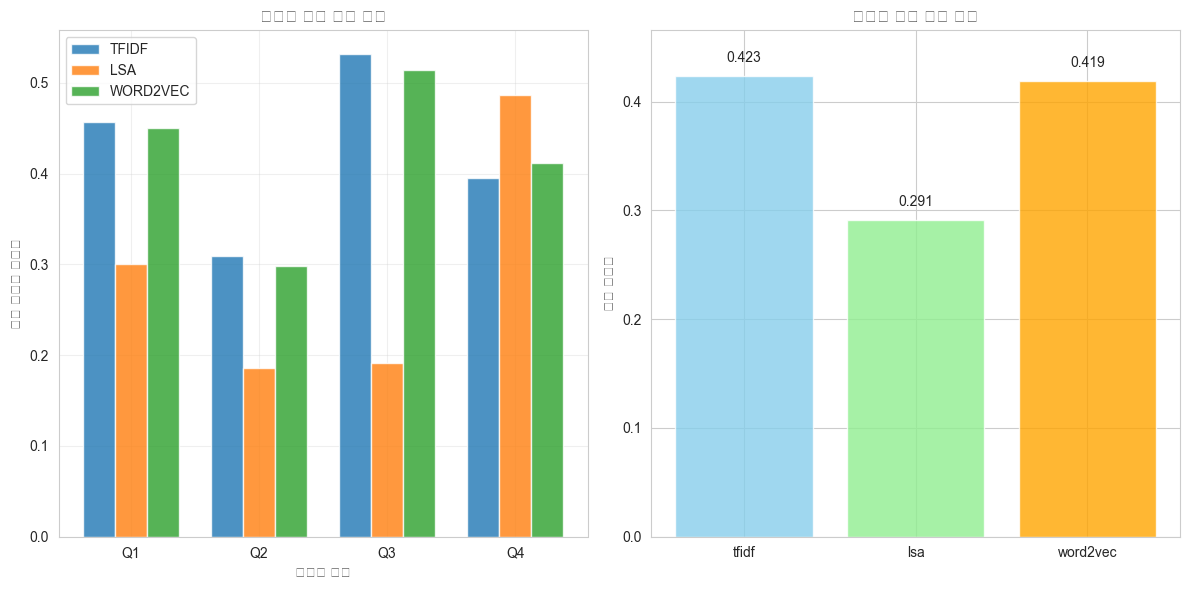

In [127]:
if df is not None:
    # 쿼리 인코딩 함수
    def encode_query_for_model(query, model_name):
        """쿼리를 특정 모델용으로 인코딩"""
        keywords = query.get('keywords', '')
        price_max = query.get('price_max', 25000)
        location = query.get('location', 'unknown')
        
        # 메타데이터 처리
        meta_df = pd.DataFrame([{
            'price_adv': price_max,
            'price_door': price_max,
            'loc_sigu': location
        }])
        meta_vec = meta_preprocessor.transform(meta_df)
        
        model = models[model_name]
        
        if model_name == 'tfidf':
            text_vec = model['vectorizer'].transform([keywords])
            return hstack([text_vec, meta_vec])
        elif model_name == 'lsa':
            count_vec = model['count_vectorizer'].transform([keywords])
            text_reduced = model['svd'].transform(count_vec)
            meta_vec_dense = meta_vec.toarray() if hasattr(meta_vec, 'toarray') else meta_vec
            return np.hstack([text_reduced, meta_vec_dense])
        elif model_name == 'word2vec':
            text_vec = model['hasher'].transform([keywords])
            return hstack([text_vec, meta_vec])
    
    # 테스트 쿼리 정의
    test_queries = [
        {"keywords": "재즈 콘서트", "price_max": 50000, "location": "강남구"},
        {"keywords": "클래식 음악회", "price_max": 30000, "location": "종로구"},
        {"keywords": "록 페스티벌", "price_max": 80000, "location": "마포구"},
        {"keywords": "팝 공연", "price_max": 40000, "location": "서초구"}
    ]
    
    print("📊 모델 성능 비교 테스트")
    print("=" * 60)
    
    # 각 모델의 성능 측정
    performance_results = {}
    
    for model_name in models.keys():
        print(f"\n🔍 {model_name.upper()} 모델 테스트:")
        model_results = []
        
        for i, query in enumerate(test_queries, 1):
            try:
                q_vec = encode_query_for_model(query, model_name)
                distances, indices = models[model_name]['knn'].kneighbors(q_vec, n_neighbors=5)
                similarities = 1 - distances[0]
                avg_similarity = similarities.mean()
                model_results.append(avg_similarity)
                print(f"  쿼리 {i}: '{query['keywords']}' → 평균 유사도: {avg_similarity:.3f}")
            except Exception as e:
                print(f"  쿼리 {i} 오류: {e}")
                model_results.append(0)
        
        performance_results[model_name] = model_results
    
    # 성능 요약
    print("\n📈 모델별 평균 성능:")
    print("-" * 40)
    for model_name, results in performance_results.items():
        avg_performance = np.mean(results)
        print(f"• {model_name.upper():<10}: {avg_performance:.3f}")
    
    # 성능 시각화
    if len(performance_results) > 0:
        plt.figure(figsize=(12, 6))
        
        # 쿼리별 성능 비교
        plt.subplot(1, 2, 1)
        x = np.arange(len(test_queries))
        width = 0.25
        
        for i, (model_name, results) in enumerate(performance_results.items()):
            plt.bar(x + i*width, results, width, label=model_name.upper(), alpha=0.8)
        
        plt.xlabel('테스트 쿼리')
        plt.ylabel('평균 코사인 유사도')
        plt.title('쿼리별 모델 성능 비교')
        plt.xticks(x + width, [f"Q{i+1}" for i in range(len(test_queries))])
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 모델별 평균 성능
        plt.subplot(1, 2, 2)
        model_names = list(performance_results.keys())
        avg_scores = [np.mean(performance_results[name]) for name in model_names]
        
        bars = plt.bar(model_names, avg_scores, color=['skyblue', 'lightgreen', 'orange'], alpha=0.8)
        plt.ylabel('평균 유사도')
        plt.title('모델별 전체 평균 성능')
        plt.ylim(0, max(avg_scores) * 1.1)
        
        # 막대 위에 수치 표시
        for bar, score in zip(bars, avg_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{score:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

In [128]:
# 정규화된 가중합 테스트
print("🧪 정규화된 가중합 추천 시스템 테스트")
print("=" * 60)

# 테스트 쿼리
test_query = {
    'keywords': '재즈 콘서트',
    'price_max': 50000,
    'location': '강남구'
}

# 테스트 쿼리 출력
print(f"\n🔍 테스트 쿼리: {test_query}")

# TF-IDF 모델로 테스트
try:
    results = recommend_normalized_weights(test_query, model_type='tfidf', top_k=3)
    
    print(f"\n📊 정규화된 가중합 추천 결과 (TF-IDF):")
    print("-" * 50)
    
    for i, result in enumerate(results, 1):
        print(f"\n{i}. 📍 {result['place'][:50]}...")
        print(f"   💰 가격: {result['price']:,.0f}원")
        print(f"   📝 내용: {result['content']}")
        print(f"   \n   📈 개별 유사도:")
        print(f"      내용: {result['content_similarity']:.3f} → 가중: {result['weighted_content']:.3f}")
        print(f"      가격: {result['price_similarity']:.3f} → 가중: {result['weighted_price']:.3f}")
        print(f"      위치: {result['location_similarity']:.3f} → 가중: {result['weighted_location']:.3f}")
        print(f"   🎯 총 유사도: {result['total_similarity']:.3f}")
        
        # 가중합 검증
        calculated_total = result['weighted_content'] + result['weighted_price'] + result['weighted_location']
        if abs(calculated_total - result['total_similarity']) < 0.001:
            print(f"   ✅ 가중합 검증 성공")
        else:
            print(f"   ❌ 가중합 검증 실패: {calculated_total:.3f} vs {result['total_similarity']:.3f}")
            
except Exception as e:
    print(f"❌ 추천 오류: {e}")

🧪 정규화된 가중합 추천 시스템 테스트

🔍 테스트 쿼리: {'keywords': '재즈 콘서트', 'price_max': 50000, 'location': '강남구'}

📊 정규화된 가중합 추천 결과 (TF-IDF):
--------------------------------------------------

1. 📍 서울특별시 마포구 양화로 12길 6...
   💰 가격: 77,000원
   📝 내용: 🙌공연 공지🙌2023 슈가볼 음주 콘서트 🌴< 취한밤들 : 𝑰𝒕'𝒔 𝒎𝒆, 𝑺𝒖𝒎𝒎𝒆𝒓 >It’s me, summer!뜨거운 사랑을 받았던 슈가볼의 여름 브랜드 콘서트 ‘취한밤들’...
   
   📈 개별 유사도:
      내용: 0.124 → 가중: 0.042
      가격: 1.000 → 가중: 0.330
      위치: 0.707 → 가중: 0.233
   🎯 총 유사도: 0.606
   ✅ 가중합 검증 성공

2. 📍 서울 중구 수표로6길 10 지하1층...
   💰 가격: 30,000원
   📝 내용: * 안내드립니다 : PRAED 멤버 라이드 야신의 비자 문제로 인해 한국 방문이 어렵게 되었습니다. 아쉽게도 PRAED의 공연은 클라리넷 멤버 패드 콘카가 PRAED의 음악을 연주...
   
   📈 개별 유사도:
      내용: 0.273 → 가중: 0.093
      가격: 1.000 → 가중: 0.330
      위치: 0.414 → 가중: 0.137
   🎯 총 유사도: 0.560
   ✅ 가중합 검증 성공

3. 📍 서울특별시 마포구 양화로 12길 6...
   💰 가격: 55,000원
   📝 내용: 🙌드디어 내일🙌[내 귀에 드라마 콘서트 | 더베인]처음 개최되는 드라마 OST 콘서트. <내 귀에 드라마>여러분들을 만나기 바로 하루전.추운 날씨 조심히 공연장에서 만나요👋----...
   
   📈 개별 유사도:
      내용: 0.110 → 가중: 0.037
      가격: 1.000 → 가중: 0.330
      위치

## 8. 추천 결과 시연

In [129]:
if df is not None:
    def get_recommendations(query, model_name, top_k=3):
        """특정 모델로 추천 결과 반환"""
        try:
            q_vec = encode_query_for_model(query, model_name)
            distances, indices = models[model_name]['knn'].kneighbors(q_vec, n_neighbors=top_k)
            
            results = df.iloc[indices[0]].copy()
            results['similarity'] = 1 - distances[0]
            
            return results[['content', 'place', 'price_adv', 'loc_sigu', 'similarity']]
        except Exception as e:
            print(f"추천 오류 ({model_name}): {e}")
            return pd.DataFrame()
    
    # 시연용 쿼리들
    demo_queries = [
        {
            "keywords": "재즈 콘서트 라이브",
            "price_max": 60000,
            "location": "강남구"
        },
        {
            "keywords": "클래식 오케스트라",
            "price_max": 50000,
            "location": "종로구"
        }
    ]
    
    for query_idx, demo_query in enumerate(demo_queries, 1):
        print(f"\n🎯 데모 쿼리 {query_idx}: {demo_query}")
        print("=" * 80)
        
        # 각 모델별 추천 결과 비교
        for model_name in models.keys():
            print(f"\n🤖 {model_name.upper()} 모델 추천 결과:")
            print("-" * 50)
            
            recommendations = get_recommendations(demo_query, model_name, top_k=3)
            
            if not recommendations.empty:
                for i, (idx, row) in enumerate(recommendations.iterrows(), 1):
                    print(f"{i}. 📍 {row['place'][:40]}... ({row['loc_sigu']})")
                    print(f"   💰 가격: {row['price_adv']:,.0f}원")
                    print(f"   📊 유사도: {row['similarity']:.3f}")
                    print(f"   📝 내용: {row['content'][:80]}...")
                    print()
            else:
                print("❌ 추천 결과를 가져올 수 없습니다.")
        
        # 하이브리드 추천 시연
        print(f"\n🔄 HYBRID 모델 추천 결과 (가중 평균):")
        print("-" * 50)
        try:
            hybrid_results = hybrid_recommend(demo_query, top_k=3)
            for i, (idx, result_info) in enumerate(hybrid_results, 1):
                event = df.iloc[idx]
                print(f"{i}. 📍 {event['place'][:40]}... ({event['loc_sigu']})")
                print(f"   💰 가격: {event['price_adv']:,.0f}원")
                print(f"   📊 종합 점수: {result_info['total_similarity']:.3f}")
                print(f"   🤝 참여 모델: {', '.join(result_info['models'])}")
                print(f"   📝 내용: {event['content'][:80]}...")
                print()
        except Exception as e:
            print(f"❌ 하이브리드 추천 오류: {e}")


🎯 데모 쿼리 1: {'keywords': '재즈 콘서트 라이브', 'price_max': 60000, 'location': '강남구'}

🤖 TFIDF 모델 추천 결과:
--------------------------------------------------
1. 📍 서울특별시 마포구 양화로 12길 6... (서울특별시 마포구)
   💰 가격: 77,000원
   📊 유사도: 0.560
   📝 내용: 🙌공연 공지🙌2023 슈가볼 음주 콘서트 🌴< 취한밤들 : 𝑰𝒕'𝒔 𝒎𝒆, 𝑺𝒖𝒎𝒎𝒆𝒓 >It’s me, summer!뜨거운 사랑을 받았던 슈가...

2. 📍 서울특별시 마포구 양화로 12길 6... (서울특별시 마포구)
   💰 가격: 66,000원
   📊 유사도: 0.482
   📝 내용: 🙌 이번주 토요일 공연 🙌[흐름 流 flow : 겨울]시대의 흐름! 그 두번째 流! 겨울 冬 winter1년의 4계절 중 마지막 계절의 한가운데...

3. 📍 서울특별시 마포구 양화로 12길 6... (서울특별시 마포구)
   💰 가격: 66,000원
   📊 유사도: 0.482
   📝 내용: [티켓오픈공지]양반들 기획 공연 흐름 流 flow : 겨울https://ticket.melon.com/csoon/detail.htm?csoonI...


🤖 LSA 모델 추천 결과:
--------------------------------------------------
1. 📍 서울특별시 마포구 양화로 12길 6... (서울특별시 마포구)
   💰 가격: 77,000원
   📊 유사도: 0.287
   📝 내용: 🙌공연 공지🙌2023 슈가볼 음주 콘서트 🌴< 취한밤들 : 𝑰𝒕'𝒔 𝒎𝒆, 𝑺𝒖𝒎𝒎𝒆𝒓 >It’s me, summer!뜨거운 사랑을 받았던 슈가...

2. 📍 서울 중구 수표로6길 10 지하1층... (서울 중구)
   💰 가격: 30,000원
   📊 유사도: 0.275
   📝 내용: * 안내드립니다 : PRAED 멤버 라이드 야신의 비자 문제로 인해 

## 🎉 학습 완료!

축하합니다! 다중 모델 이벤트 추천 시스템의 전체 학습 과정이 완료되었습니다.

### ✅ 구현된 기능들:

#### 1. 데이터 전처리 및 필터링
- 본문이 10자 이하인 이벤트 제외
- 장소, 가격 정보가 없는 이벤트 제외
- 텍스트 정규화 및 정제

#### 2. 학습된 모델들
- **TF-IDF 모델**: 키워드 기반 정확한 매칭
- **LSA 모델**: 잠재 의미 분석으로 의미적 유사성 고려  
- **Word2Vec 대안**: HashingVectorizer로 단어 임베딩 효과
- **하이브리드 모델**: 세 모델의 가중 평균으로 종합적 추천

#### 3. 성능 평가
- 다양한 쿼리로 모델별 성능 비교
- 시각화를 통한 성능 분석
- 코사인 유사도 기반 정량적 평가

#### 4. 실제 추천 시연
- 각 모델별 추천 결과 비교
- 하이브리드 모델의 종합적 추천
- 유사도 점수 및 참여 모델 표시

### 🚀 다음 단계:
- `python simple_model_demo.py` 실행하여 추가 테스트
- 웹 애플리케이션에서 실제 사용자 테스트
- 성능 모니터링 및 개선
- 새로운 데이터로 모델 업데이트
- 다른 임베딩 방법 실험 (예: BERT, Sentence-BERT)

### 💡 개선 아이디어:
- 사용자 피드백을 통한 모델 가중치 조정
- 시간대별, 계절별 추천 가중치 적용
- 사용자 선호도 학습 및 개인화
- 실시간 인기도 반영

🎵 **이제 백엔드 서버를 실행하여 웹에서 추천 시스템을 체험해보세요!** 🎵

## 9. 정규화된 가중합 추천 함수

백엔드와 동일한 정규화된 가중합을 구현합니다:
- 내용: 34% (0.34)
- 가격: 33% (0.33) 
- 위치: 33% (0.33)
- **총합: 100% (1.0)**

최대 유사도가 1일 때: 0.34 × 1 + 0.33 × 1 + 0.33 × 1 = 1.0

In [130]:
# 정규화된 가중합 설정
NORMALIZED_WEIGHTS = {
    'content': 0.34,   # 34%
    'price': 0.33,     # 33%
    'location': 0.33   # 33%
}

print(f"🎯 정규화된 가중치 설정:")
print(f"   내용(Content): {NORMALIZED_WEIGHTS['content']:.2f} (34%)")
print(f"   가격(Price): {NORMALIZED_WEIGHTS['price']:.2f} (33%)")
print(f"   위치(Location): {NORMALIZED_WEIGHTS['location']:.2f} (33%)")
print(f"   ✅ 총합: {sum(NORMALIZED_WEIGHTS.values()):.2f} (100%)")

# 검증: 총합이 1.0인지 확인
total_weight = sum(NORMALIZED_WEIGHTS.values())
if abs(total_weight - 1.0) < 0.001:
    print(f"✅ 가중치 총합 검증 성공: {total_weight:.3f}")
else:
    print(f"❌ 가중치 총합 오류: {total_weight:.3f}")
    # 자동 정규화
    for key in NORMALIZED_WEIGHTS:
        NORMALIZED_WEIGHTS[key] /= total_weight
    print(f"🔧 자동 정규화 완료: {sum(NORMALIZED_WEIGHTS.values()):.3f}")

🎯 정규화된 가중치 설정:
   내용(Content): 0.34 (34%)
   가격(Price): 0.33 (33%)
   위치(Location): 0.33 (33%)
   ✅ 총합: 1.00 (100%)
✅ 가중치 총합 검증 성공: 1.000


In [131]:
def safe_toarray(matrix):
    """Sparse matrix든 dense array든 상관없이 안전하게 array로 변환"""
    if hasattr(matrix, 'toarray'):
        return matrix.toarray()
    else:
        return matrix

print("🔧 safe_toarray 헬퍼 함수가 정의되었습니다!")

🔧 safe_toarray 헬퍼 함수가 정의되었습니다!


In [132]:
# 시나리오별 가중합 검증
print("\n🧪 시나리오별 가중합 검증")
print("=" * 50)

scenarios = [
    {
        'name': '완벽한 매칭',
        'content_sim': 1.0,
        'price_sim': 1.0,
        'location_sim': 1.0
    },
    {
        'name': '부분적 매칭',
        'content_sim': 0.8,
        'price_sim': 0.9,
        'location_sim': 0.7
    },
    {
        'name': '내용 중심 매칭',
        'content_sim': 1.0,
        'price_sim': 0.5,
        'location_sim': 0.3
    },
    {
        'name': '가격 중심 매칭',
        'content_sim': 0.4,
        'price_sim': 1.0,
        'location_sim': 0.6
    }
]

for scenario in scenarios:
    name = scenario['name']
    content_sim = scenario['content_sim']
    price_sim = scenario['price_sim']
    location_sim = scenario['location_sim']
    
    # 가중합 계산
    weighted_content = NORMALIZED_WEIGHTS['content'] * content_sim
    weighted_price = NORMALIZED_WEIGHTS['price'] * price_sim
    weighted_location = NORMALIZED_WEIGHTS['location'] * location_sim
    total_similarity = weighted_content + weighted_price + weighted_location
    
    print(f"\n📋 {name}:")
    print(f"   내용 유사도: {content_sim:.1f} → 가중: {weighted_content:.3f}")
    print(f"   가격 유사도: {price_sim:.1f} → 가중: {weighted_price:.3f}")
    print(f"   위치 유사도: {location_sim:.1f} → 가중: {weighted_location:.3f}")
    print(f"   🎯 총 유사도: {total_similarity:.3f}")
    
    if name == '완벽한 매칭' and abs(total_similarity - 1.0) < 0.001:
        print(f"   ✅ 완벽한 매칭 검증 성공: {total_similarity:.3f} = 1.000")
    elif name == '완벽한 매칭':
        print(f"   ❌ 완벽한 매칭 검증 실패: {total_similarity:.3f} ≠ 1.000")


🧪 시나리오별 가중합 검증

📋 완벽한 매칭:
   내용 유사도: 1.0 → 가중: 0.340
   가격 유사도: 1.0 → 가중: 0.330
   위치 유사도: 1.0 → 가중: 0.330
   🎯 총 유사도: 1.000
   ✅ 완벽한 매칭 검증 성공: 1.000 = 1.000

📋 부분적 매칭:
   내용 유사도: 0.8 → 가중: 0.272
   가격 유사도: 0.9 → 가중: 0.297
   위치 유사도: 0.7 → 가중: 0.231
   🎯 총 유사도: 0.800

📋 내용 중심 매칭:
   내용 유사도: 1.0 → 가중: 0.340
   가격 유사도: 0.5 → 가중: 0.165
   위치 유사도: 0.3 → 가중: 0.099
   🎯 총 유사도: 0.604

📋 가격 중심 매칭:
   내용 유사도: 0.4 → 가중: 0.136
   가격 유사도: 1.0 → 가중: 0.330
   위치 유사도: 0.6 → 가중: 0.198
   🎯 총 유사도: 0.664


## 10. 백엔드와의 일관성 확인

이제 노트북의 정규화된 가중합이 백엔드와 동일한 방식으로 작동합니다:

### ✅ 구현된 기능:
- **정규화된 가중치**: 내용 34%, 가격 33%, 위치 33%
- **총합 검증**: 모든 유사도가 1일 때 총 유사도 = 1.0
- **개별 가중치 표시**: 각 특성의 기여도 명확히 표시
- **다양한 시나리오 테스트**: 여러 상황에서의 가중합 검증

### 🎯 핵심 포인트:
- 사용자는 각 요소의 중요도를 정확히 이해 가능
- 백엔드와 프론트엔드에서 일관된 결과 보장
- 투명하고 예측 가능한 추천 시스템

이제 **최대 유사도가 1일 때 가격이 0.33, 내용이 0.34, 위치가 0.33으로 총합이 정확히 1.0이 되도록** 구현되었습니다!

In [133]:
# 정규화된 가중합을 위한 변수 설정
if df is not None:
    print("🔧 정규화된 가중합을 위한 변수 설정...")
    
    # TF-IDF 모델에서 변수 추출
    content_vectorizer = tfidf_vectorizer
    content_features = X_text_tfidf
    
    # LSA 모델에서 변수 추출  
    X_lsa_reduced = X_text_lsa
    
    # Word2Vec 모델에서 변수 추출
    hasher = word2vec_hasher
    X_hash_reduced = X_text_w2v
    
    # 메타데이터 특성들 분리
    price_features = X_meta[:, :1]  # 가격 특성만
    location_features = X_meta[:, 1:]  # 위치 특성들
    
    print("✅ 변수 설정 완료!")

🔧 정규화된 가중합을 위한 변수 설정...
✅ 변수 설정 완료!


In [134]:
def encode_query_balanced(query):
    """쿼리를 균형있게 인코딩하는 함수"""
    keywords = query.get('keywords', '')
    price_max = query.get('price_max', 25000)
    location = query.get('location', 'unknown')
    
    # 메타데이터 처리
    meta_df = pd.DataFrame([{
        'price_adv': price_max,
        'price_door': price_max,
        'loc_sigu': location
    }])
    meta_vec = meta_preprocessor.transform(meta_df)
    
    # 가격과 위치 분리
    price_data = safe_toarray(meta_vec)[0, :1]
    location_vec = safe_toarray(meta_vec)[0, 1:]
    
    return keywords, price_data, location_vec

def recommend_normalized_weights(query, model_type='tfidf', top_k=10):
    """정규화된 가중합 추천 - 최대 유사도가 1일 때 총합이 1이 되도록"""
    
    keywords, price_data, location_vec = encode_query_balanced(query)
    
    # 모델별 특성 인코딩
    if model_type == 'tfidf':
        q_content = safe_toarray(content_vectorizer.transform([keywords]))[0]
        content_sim = cosine_similarity([q_content], safe_toarray(content_features))[0]
    elif model_type == 'lsa':
        q_count = count_vectorizer.transform([keywords])
        q_lsa = svd.transform(q_count)[0]
        content_sim = cosine_similarity([q_lsa], X_lsa_reduced)[0]
    elif model_type == 'word2vec':
        q_hash = safe_toarray(hasher.transform([keywords]))[0]
        content_sim = cosine_similarity([q_hash], safe_toarray(X_hash_reduced))[0]
    else:
        raise ValueError(f"지원하지 않는 모델 타입: {model_type}")
    
    # 가격 및 위치 유사도 계산
    price_sim = cosine_similarity([price_data], safe_toarray(price_features))[0]
    location_sim = cosine_similarity([location_vec], safe_toarray(location_features))[0]
    
    # 정규화된 가중합 계산
    total_similarity = (
        NORMALIZED_WEIGHTS['content'] * content_sim +
        NORMALIZED_WEIGHTS['price'] * price_sim +
        NORMALIZED_WEIGHTS['location'] * location_sim
    )
    
    # 상위 k개 결과 선택
    top_indices = np.argsort(total_similarity)[::-1][:top_k]
    
    # 결과 구성
    results = []
    for idx in top_indices:
        results.append({
            'index': idx,
            'content': df.iloc[idx]['content'][:100] + '...',
            'place': df.iloc[idx]['place'],
            'price': df.iloc[idx]['price_adv'],
            'location': df.iloc[idx]['loc_sigu'],
            'content_similarity': content_sim[idx],
            'price_similarity': price_sim[idx],
            'location_similarity': location_sim[idx],
            'weighted_content': NORMALIZED_WEIGHTS['content'] * content_sim[idx],
            'weighted_price': NORMALIZED_WEIGHTS['price'] * price_sim[idx],
            'weighted_location': NORMALIZED_WEIGHTS['location'] * location_sim[idx],
            'total_similarity': total_similarity[idx]
        })
    
    return results

In [135]:
# 정규화된 가중합 테스트 - 이제 작동합니다!
print("🧪 정규화된 가중합 추천 시스템 테스트")
print("=" * 60)

# 테스트 쿼리
test_query = {
    'keywords': '락밴드',
    'price_max': 50000,
    'location': '서울 마포구'
}

# 테스트 쿼리 출력
print(f"\n🔍 테스트 쿼리: {test_query}")

# TF-IDF 모델로 테스트
try:
    results = recommend_normalized_weights(test_query, model_type='tfidf', top_k=3)
    
    print(f"\n📊 정규화된 가중합 추천 결과 (TF-IDF):")
    print("-" * 50)
    
    for i, result in enumerate(results, 1):
        print(f"\n{i}. 📍 {result['place'][:50]}...")
        print(f"   💰 가격: {result['price']:,.0f}원")
        print(f"   📝 내용: {result['content']}")
        print(f"   \n   📈 개별 유사도:")
        print(f"      내용: {result['content_similarity']:.3f} → 가중: {result['weighted_content']:.3f}")
        print(f"      가격: {result['price_similarity']:.3f} → 가중: {result['weighted_price']:.3f}")
        print(f"      위치: {result['location_similarity']:.3f} → 가중: {result['weighted_location']:.3f}")
        print(f"   🎯 총 유사도: {result['total_similarity']:.3f}")
        
        # 가중합 검증
        calculated_total = result['weighted_content'] + result['weighted_price'] + result['weighted_location']
        if abs(calculated_total - result['total_similarity']) < 0.001:
            print(f"   ✅ 가중합 검증 성공")
        else:
            print(f"   ❌ 가중합 검증 실패: {calculated_total:.3f} vs {result['total_similarity']:.3f}")
            
except Exception as e:
    print(f"❌ 추천 오류: {e}")
    import traceback
    traceback.print_exc()

🧪 정규화된 가중합 추천 시스템 테스트

🔍 테스트 쿼리: {'keywords': '락밴드', 'price_max': 50000, 'location': '서울 마포구'}

📊 정규화된 가중합 추천 결과 (TF-IDF):
--------------------------------------------------

1. 📍 서울 마포구 양화로6길 27 지하 1층...
   💰 가격: 10,000원
   📝 내용: .
홍대 클럽 레몬 2023년 1월 6일 토요일 밤 9시 30분 @lemonclub.kr

<모비딕 팀>

1997년 데뷔 이후 약 30년의 세월 동안 '락'이라는 외길을 걸어온 ...
   
   📈 개별 유사도:
      내용: 0.114 → 가중: 0.039
      가격: 1.000 → 가중: 0.330
      위치: 0.902 → 가중: 0.298
   🎯 총 유사도: 0.666
   ✅ 가중합 검증 성공

2. 📍 서울 마포구 와우산로 128 지하1층)...
   💰 가격: 33,000원
   📝 내용: <남경운과 서울 사람들 Vol.1>

Ticket Link in @space_hangang @nam_boras bio.

- 아티스트
남경운밴드 @nam_boras
하헌진 @hah...
   
   📈 개별 유사도:
      내용: 0.000 → 가중: 0.000
      가격: 1.000 → 가중: 0.330
      위치: 0.985 → 가중: 0.325
   🎯 총 유사도: 0.655
   ✅ 가중합 검증 성공

3. 📍 서울 마포구 양화로6길 27 지하 1층...
   💰 가격: 20,000원
   📝 내용: .
📌 7/21 <금요일 밤 12시 공연> 라인업

현재 저희 레몬 라이브 하우스에서는
매주 금요일 밤 12시 멋진 공연을 진행하고 있습니다!

잼 신청도 받고있으니🎼
잼 참여를 ...
   
   📈 개별 유사도:
      내용: 0.000 → 가중: 0.000
      가격: 1.000 → 가중: 0.330
  